# Predicting Diabetic Patient Readmissions with Machine Learning

<p><a name="sections"></a></p>


# Table of Contents

- <a href="#intro">Introduction</a><br>
 - <a href="#motivation">Motivation</a><br>
 - <a href="#dataset">Dataset</a><br>
 - <a href="#process">Process</a><br>
 - <a href="#eval">Model Evaluation</a><br>
 
- <a href="#importshelp">Imports and Helper Functions</a><br>
 - <a href="#modules">Importing Libraries</a><br>
 - <a href="#helper">Helper Functions</a><br>
- <a href="#processing">Data Processing</a><br>
 - <a href="#missing">Missing Values</a><br>
 - <a href="#featprocessing">Feature Processing</a><br>
 - <a href="#numcat">Preprocessing Numeric and Categorical Features</a><br>
 - <a href="#encodescale">Encoding/Scaling</a><br>
 - <a href="#upsampling">Addressing Imbalanced Dataset</a><br>
- <a href="#base">Base Machine Learning Algorithms</a><br>
 - <a href="#dt">Decision Trees</a><br>
 - <a href="#lr">Logistic Regression</a><br>
 - <a href="#rf">Random Forest</a><br>
 - <a href="#xgb">XGBoost</a><br>
- <a href="#optimized">Optimized Machine Learning Algorithms</a><br>
 - <a href="#dt2">Decision Trees</a><br>
 - <a href="#lr2">Logistic Regression</a><br>
 - <a href="#rf2">Random Forest</a><br>
 - <a href="#xgb2">XGBoost</a><br>
- <a href="#conc">Conclusion</a><br>

<p><a name="intro"></a></p>

# Introduction

The goal of this project is to develop a predictive model which will help hospitals reduce their readmission rates among diabetic patients. 

<p><a name="motivation"></a></p>

## Motivation

In an effort to improve the quality of hospital care in the United States, the Affordable Care Act created the Hospital Readmission Reduction Program to improve the quality of healthcare for Americans by tying the payments to hospitals to patient readmission rates. In other words, this program seeks to incentivize hospitals to provide high quality healthcare by financially penalizing                 


A goal of the Affordable Health Care act is to increase the quality of hospital care in U.S hospitals.  One specific issue area in which hospitals can improve quality is by improving hospital readmission rates.  Under the Affordable Care Act, CMS created the Hospital Readmission Reduction Program in order to link payment data to the quality of hospital care in order to improve health quality for Americans.  Essentially, payments to Inpatient Prospective Payment System (IPPS) hospitals depend on each hospital’s readmission rates.  Hospitals with poor readmission performance are financially penalized through reduced payments.

<p><a name="dataset"></a></p>

## Dataset

https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008

Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore, “Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records,” BioMed Research International, vol. 2014, Article ID 781670, 11 pages, 2014. 

<p><a name="process"></a></p>

## Process

The goal is to implement Random Forest,Logistic Regression and Support Vector Machine algorithms. This is done by setting up a model relating the inputs (features) to the outputs (response), creating test samples and training samples and running the models. The end result is a model accuracy score, model classification report, model confusion matrix and a ROC curve.

The basic outline is as follows:

1. Exploratory Data Analysis
2. Split data into training and testing sets
3. Establish Naive Benchmark
4. Create our machine learning model
5. Evaluate several standard machine learning approached for performance
6. Compare the performance of the naive model to standard machine learning methods
7. Draw conclusions and outline future work opportunities


<p><a name="eval"></a></p>

## Model Evaluation

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

True Positive Rate
False Positive Rate
True Positive Rate (TPR) is a synonym for recall and is therefore defined as follows:

False Positive Rate (FPR) is defined as follows:

An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve.

ROC Curve showing TP Rate vs. FP Rate at different classification thresholds.
Figure 4. TP vs. FP rate at different classification thresholds.

To compute the points in an ROC curve, we could evaluate a logistic regression model many times with different classification thresholds, but this would be inefficient. Fortunately, there's an efficient, sorting-based algorithm that can provide this information for us, called AUC.

AUC: Area Under the ROC Curve
AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1).

AUC (Area under the ROC Curve).
Figure 5. AUC (Area under the ROC Curve).

AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example. For example, given the following examples, which are arranged from left to right in ascending order of logistic regression predictions:

Positive and negative examples ranked in ascending order of logistic regression score
Figure 6. Predictions ranked in ascending order of logistic regression score.

AUC represents the probability that a random positive (green) example is positioned to the right of a random negative (red) example.

AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

AUC is desirable for the following two reasons:

AUC is scale-invariant. It measures how well predictions are ranked, rather than their absolute values.
AUC is classification-threshold-invariant. It measures the quality of the model's predictions irrespective of what classification threshold is chosen.
However, both these reasons come with caveats, which may limit the usefulness of AUC in certain use cases:

Scale invariance is not always desirable. For example, sometimes we really do need well calibrated probability outputs, and AUC won’t tell us about that.

Classification-threshold invariance is not always desirable. In cases where there are wide disparities in the cost of false negatives vs. false positives, it may be critical to minimize one type of classification error. For example, when doing email spam detection, you likely want to prioritize minimizing false positives (even if that results in a significant increase of false negatives). AUC isn't a useful metric for this type of optimization.

https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

<p><a name="importshelp"></a></p>

# Imports and Helper Functions

<p><a name="modules"></a></p>

## Importing Libraries

In [1]:
# pandas and numpy for data analysis
import pandas as pd 
import numpy as np 

# data visualization packages 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline
pd.set_option('max_columns', None)

# SMOTE package to address imbalanced classes 
from imblearn.over_sampling import SMOTE 

# machine learning packages (sklearn + xgboost)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from warnings import filterwarnings
filterwarnings('ignore')

<p><a name="helper"></a></p>

### Helper Functions

In [2]:
# Center Plot
def center_plot():
    from IPython.core.display import HTML
    HTML("""
    <style>
    .output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
    }
    </style>
    """)

In [3]:
# Plot Confusion Matrix
def plot_cm(estimator,title):
    '''Plots confusion matrix
    
    Plots confusion matrix
    
    Args:
        model: 
            Trained (fitted) ML algorithm
        title:
            Machine algorithm that corresponds with the estimator to insert into title of plot
    Returns: 
        Plot of confusion matrix for unseen test data set
        
    '''        
    
    from sklearn.metrics import plot_confusion_matrix
    
    plt.figure(figsize=(10,8))
    plot_confusion_matrix(estimator, X=X_test, y_true=y_test, display_labels=['Not Readmitted', 'Readmitted'], cmap='Blues', values_format='d')
    plt.title(str(title)+' '+'Confusion Matrix')
    
    from IPython.core.display import HTML
    HTML("""
    <style>
    .output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
    }
    </style>
    """)


In [4]:
# Plot ROC Curve
def plot_roc_curve(model, X_test, y_test, title = "ROC Curve"):
    '''Plots roc curve
    
    Plots ROC curve 
    
    Args:
        model: 
            Machine learning algorithm to evaluate
        X_test: 
            Test data to evaluate
        y_test:
            Test outputs 
        title:
            Title for plot            
    Returns: 
        An ROC curving allowing for comparison of false positive vs true postive rates
        
    '''    
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize = (10,8))
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = "AUC = %0.2f"%roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0,1],[0,1], 'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    
    from IPython.core.display import HTML
    HTML("""
    <style>
    .output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
    }
    </style>
    """)
    
    plt.show()

In [5]:
# Plot Feature Importance
def plot_feature_importance(values, names, model_name, n_features=10):
    '''Plots feature importances 
    
    Plots top important features for a given model
    
    Args:
        values: 
            Feature importance values for a given model
        names: 
            Feature names from training data set
        n_features: 
            Number of features to show - default is 10
            
    Returns: 
        A bar plot showing the top n_features. 
        
    '''
    # make arrays for feature importance values and names 
    feature_importance = np.array(values)
    feature_names = np.array(names)
    
    # create DataFrame and sort by feature importance
    data = {'Feature':feature_names, 'Feature Importance':feature_importance}
    fidf = pd.DataFrame(data)
    fidf = fidf.sort_values('Feature Importance', ascending=False).head(n_features)
    
    # plot figure
    plt.figure(figsize = (10,8))
    sns.barplot(x=fidf['Feature Importance'], y=fidf['Feature'], palette='coolwarm')
    plt.title(model_name + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    
    from IPython.core.display import HTML
    HTML("""
    <style>
    .output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
    }
    </style>
    """)

<p><a name="processing"></a></p>

# Data Processing

In [6]:
df = pd.read_csv('./data/diabetic_data.csv', na_values='?')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


<p><a name="missing"></a></p>

## Missing Values

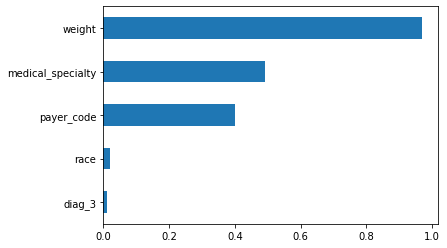

In [7]:
missing = round((df.isna().sum()/len(df)),2).sort_values(ascending = True)
missing = missing[missing > 0]
missing.plot(kind='barh')

In [8]:
# drop weight
drop_cols = ['encounter_id', 'weight','admission_type_id',
 'discharge_disposition_id',
 'admission_source_id', 'diag_1','diag_2','diag_3', 'examide','citoglipton']
df.drop(drop_cols, axis=1, inplace = True)

df.drop_duplicates('patient_nbr', keep = 'first')
df.drop('patient_nbr', axis = 1, inplace = True)

In [9]:
# payer code - mode
df.loc[df['payer_code'].isnull(), 'payer_code'] = df['payer_code'].value_counts().index[0]

In [10]:
# drop medical specialty column
print('Number of unique medical specialty',str(len(df['medical_specialty'].unique())))
df.drop('medical_specialty', axis=1, inplace=True)

Number of unique medical specialty 73


In [11]:
# remaining missing values
df.dropna(axis=0, inplace=True)
print('Number of missing values: ',str((df.isna().sum() > 0).sum()))

Number of missing values:  0


<p><a name="featprocessing"></a></p>

## Feature Processing

In [12]:
## gender
df = df[df['gender']!='Unknown/Invalid']

In [13]:
df['age'] = df['age'].map({'[10-20)':1, '[20-30)':2, '[30-40)':3, '[40-50)':4, '[50-60)':5, '[60-70)':6,
                           '[70-80)':7, '[80-90)':8, '[90-100)':9, '[0-10)':0})

In [14]:
df['max_glu_serum'] = df['max_glu_serum'].map({'None':0, 'Norm':100, '>200':200, '>300':300})

In [15]:
df['A1Cresult']= df.A1Cresult.map({'None':0,'Norm':3,'>7':7,'>8':8})

In [16]:
medication = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

for med in medication:
    df[med] = df[med].map({'Up':1, 'Down':1, 'Steady':1, 'No':0})

In [17]:
df['change'] = df['change'].map({'Ch':1,'No':0})

In [18]:
df['diabetesMed'] = df.diabetesMed.map({'Yes':1, 'No':0})

In [19]:
df['readmitted'] = df.readmitted.map({'NO':0, '>30':0, '<30':1})

<p><a name="numcat"></a></p>

## Preprocessing Numeric and Categorical Features

In [20]:
categorical = []
continuous = []

for col in df.columns:
    if df[col].dtype == 'O':
        categorical.append(col)
    elif col != 'readmitted':
        continuous.append(col)
        
print(categorical, end = '\n')
print(continuous)


['race', 'gender', 'payer_code']
['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


<p><a name="encodescale"></a></p>

## Encoding / Scaling

In [21]:
X = df.drop('readmitted', axis = 1)
y = df['readmitted']

In [22]:
X = pd.get_dummies(X, columns = categorical)

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

<p><a name="upsampling"></a></p>

## Addressing Imbalanced Dataset

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, stratify = y, random_state = 42)

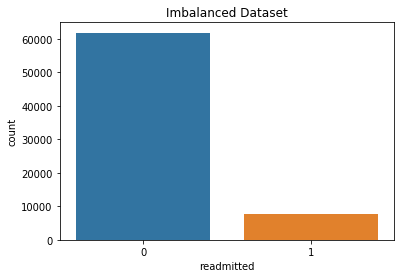

In [25]:
plt.figure(figsize=(6,4))
sns.countplot(y_train)
plt.title('Imbalanced Dataset')
plt.show()

In [26]:
# SMOTE 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

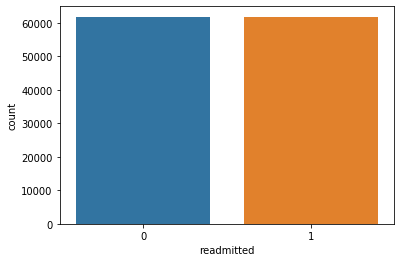

In [27]:
plt.figure(figsize=(6,4))
sns.countplot(y_train_res)

<p><a name="base"></a></p>

# Base Machine Learning Algorithms


<p><a name="dt"></a></p>

## Decision Tree Classifer



In [28]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train_res, y_train_res)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

<Figure size 720x576 with 0 Axes>

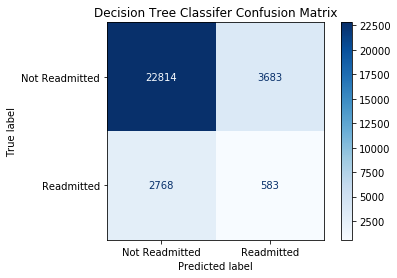

In [29]:
plot_cm(dt_clf, "Decision Tree Classifer")

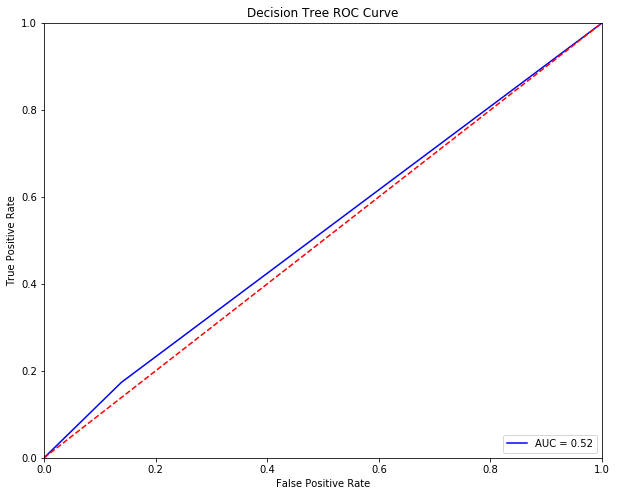

In [30]:
plot_roc_curve(dt_clf, X_test, y_test, "Decision Tree ROC Curve")

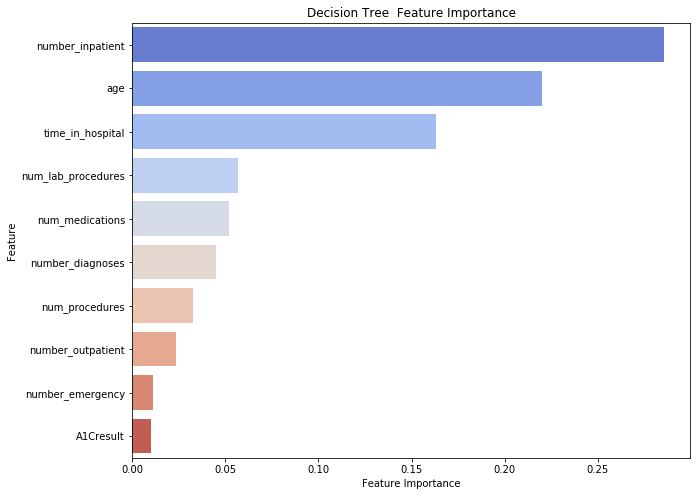

In [31]:
plot_feature_importance(dt_clf.feature_importances_, X_train_res.columns, "Decision Tree ")

<p><a name="lr"></a></p>

## Logistic Regression Classifier



In [32]:
logmodel = LogisticRegression()
logmodel.fit(X_train_res, y_train_res)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<Figure size 720x576 with 0 Axes>

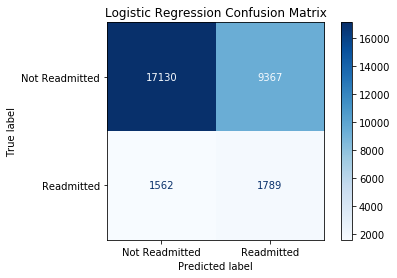

In [33]:
plot_cm(logmodel, 'Logistic Regression')



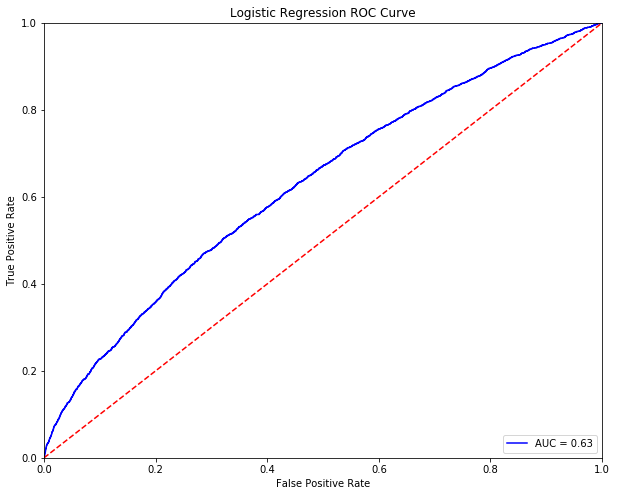

In [34]:
plot_roc_curve(logmodel, X_test, y_test, 'Logistic Regression ROC Curve')

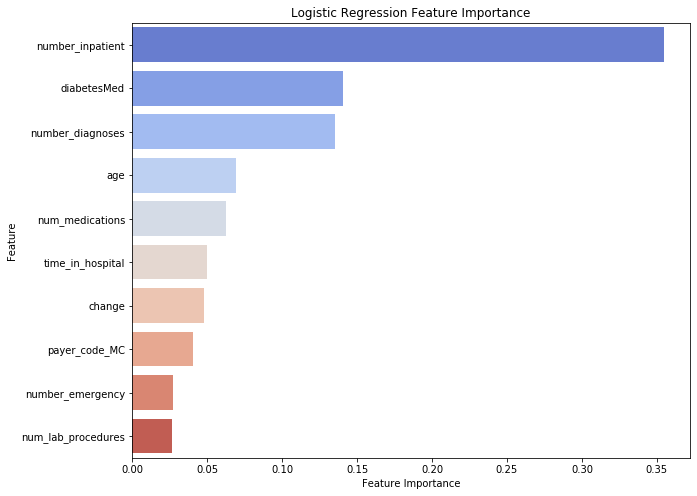

In [35]:
plot_feature_importance(logmodel.coef_.reshape(logmodel.coef_.shape[1],), X_train_res.columns, 'Logistic Regression')

<p><a name="rf"></a></p>

## Random Forest Classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_jobs = -1)

rf_clf.fit(X_train_res, y_train_res)
rf_preds = rf_clf.predict(X_test)

<Figure size 720x576 with 0 Axes>

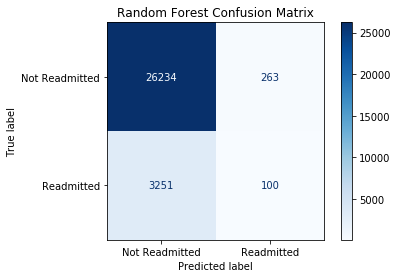

In [37]:
plot_cm(rf_clf, 'Random Forest')

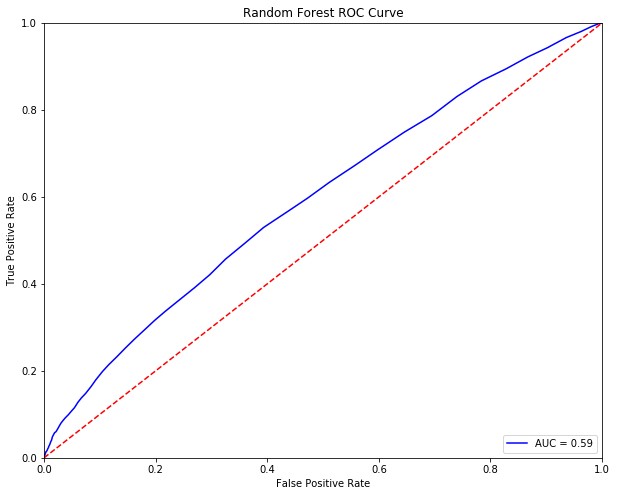

In [38]:
plot_roc_curve(rf_clf, X_test, y_test, title = "Random Forest ROC Curve")

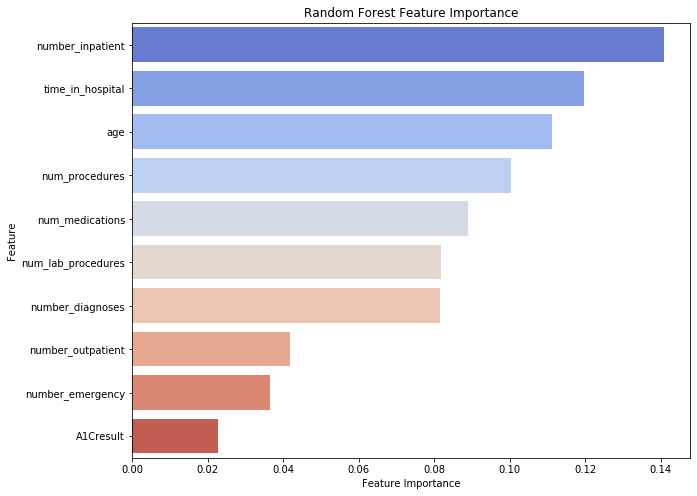

In [39]:
plot_feature_importance(rf_clf.feature_importances_, X_train_res.columns, 'Random Forest')

<p><a name="xgb"></a></p>

## XGBoost Classifier

In [40]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed = 42)
xgb_clf.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

<Figure size 720x576 with 0 Axes>

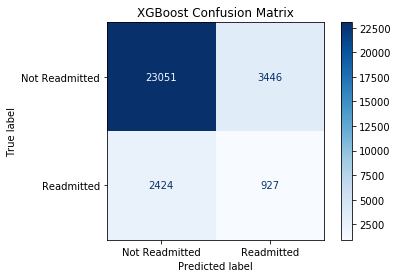

In [41]:
plot_cm(xgb_clf, "XGBoost")

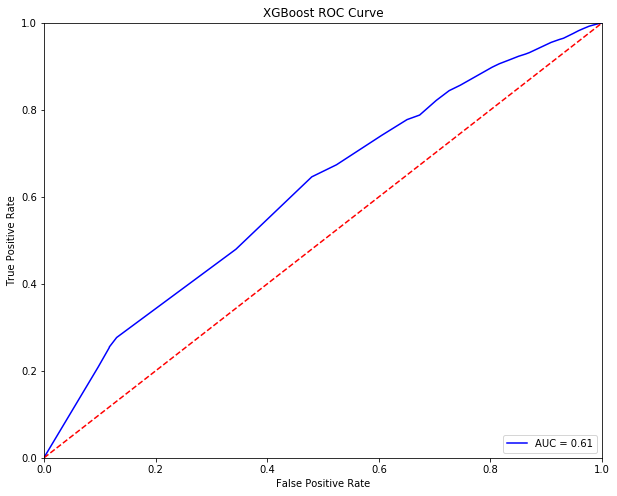

In [42]:
plot_roc_curve(xgb_clf, X_test, y_test,  title="XGBoost ROC Curve")

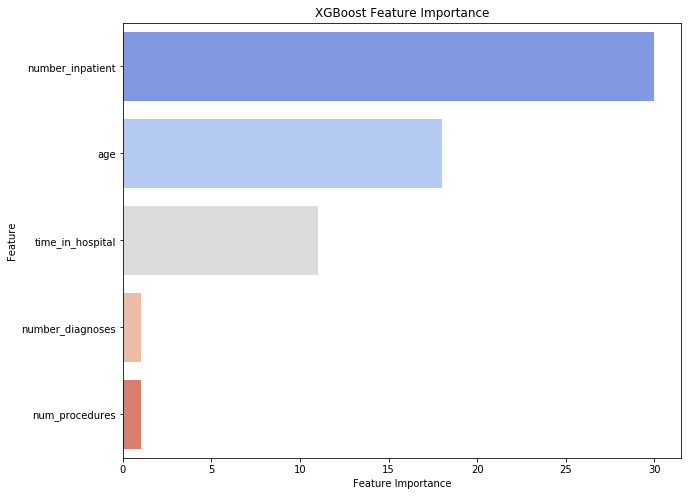

In [43]:
feature_important = xgb_clf.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

xgb_df = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

plot_feature_importance(xgb_df.score, xgb_df.index, "XGBoost")

# Evaluating Different Models

DT: 0.872454 (0.085242)
LR: 0.642659 (0.003398)
RF: 0.983314 (0.032775)
XGB: 0.834762 (0.070686)


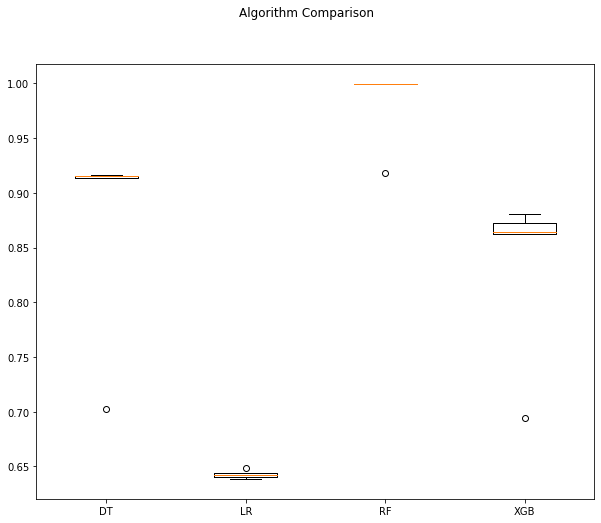

In [44]:
models = []
models.append(('DT', dt_clf))
models.append(('LR', logmodel))
models.append(('RF', rf_clf))
models.append(('XGB', xgb_clf))

# evaluate each model in turn
results = []
names = []
scoring = 'roc_auc'
for name, model in models:
    cv_results = cross_val_score(model, X_train_res, y_train_res, cv=5, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure(figsize=(10,8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

<p><a name="optimized"></a></p>

# Optimized Machine Learning Algorithms


## Decision Tree Hyperparameter Tuning

In [45]:
max_depth = list(range(1,15,2))
max_features = list(range(1,9))
min_samples_leaf = list(range(2,10,2))
criterion = ['gini', 'entropy']


params_dt = {'max_depth':max_depth, 
            'max_features':max_features, 
            'min_samples_leaf':min_samples_leaf,
            'criterion':criterion}

dt = DecisionTreeClassifier()

dt_cv = GridSearchCV(dt, params_dt, cv=5, verbose=1, n_jobs=-1)

dt_cv.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 448 candidates, totalling 2240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2240 out of 2240 | elapsed:  1.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                     

In [46]:
dt_cv.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=13, max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

<Figure size 720x576 with 0 Axes>

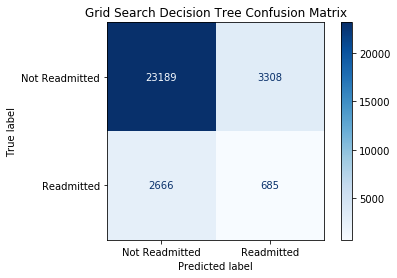

In [47]:
plot_cm(dt_cv.best_estimator_, "Grid Search Decision Tree")

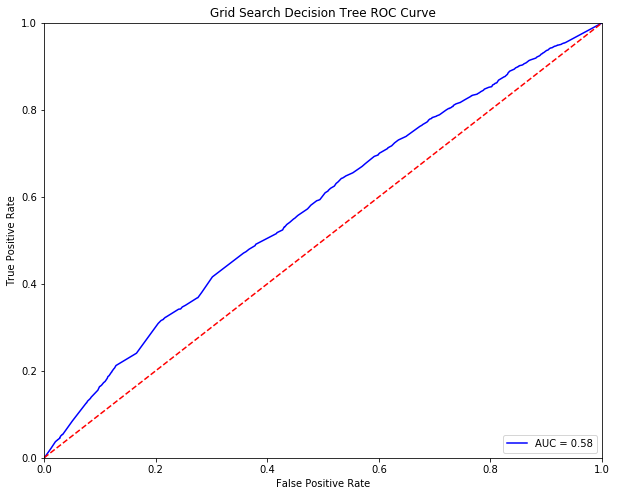

In [48]:
plot_roc_curve(dt_cv.best_estimator_, X_test, y_test, 'Grid Search Decision Tree ROC Curve')

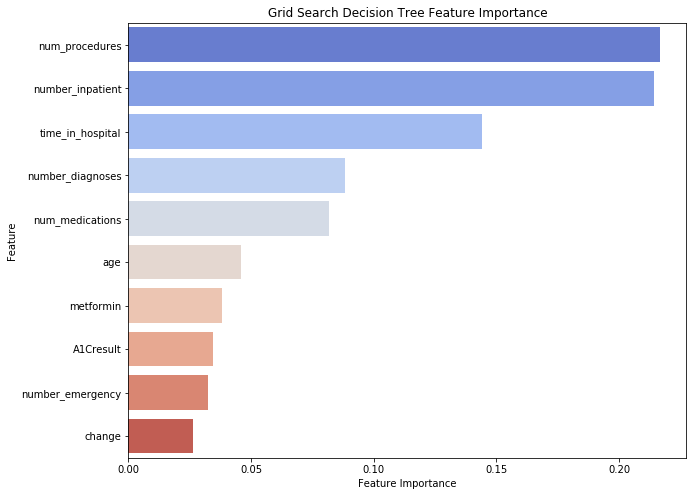

In [49]:
plot_feature_importance(dt_cv.best_estimator_.feature_importances_, 
                        X_train_res.columns, "Grid Search Decision Tree")

## Logistic Regression Hyperparameter Tuning

In [50]:
penalty = ['l1', 'l2']
C = np.logspace(0,4,10)

params_lr = {'penalty':penalty, 'C':C}

lr = LogisticRegression()

lr_cv = GridSearchCV(lr, param_grid=params_lr, cv=5, verbose=1, n_jobs=-1, scoring='roc_auc')

lr_cv.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             s

In [51]:
lr_cv.best_estimator_

LogisticRegression(C=21.544346900318832, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<Figure size 720x576 with 0 Axes>

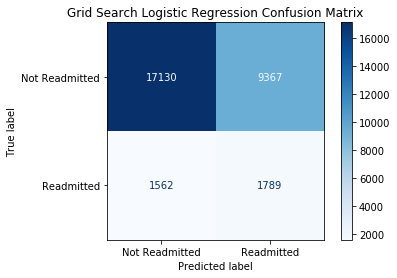

In [52]:
plot_cm(lr_cv, "Grid Search Logistic Regression")

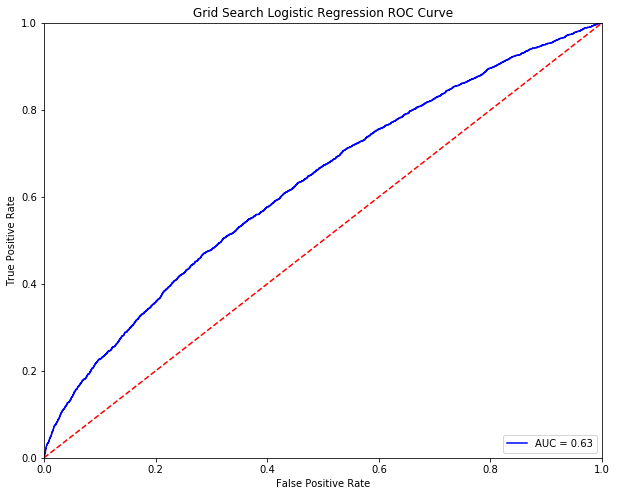

In [53]:
plot_roc_curve(lr_cv, X_test, y_test, "Grid Search Logistic Regression ROC Curve")

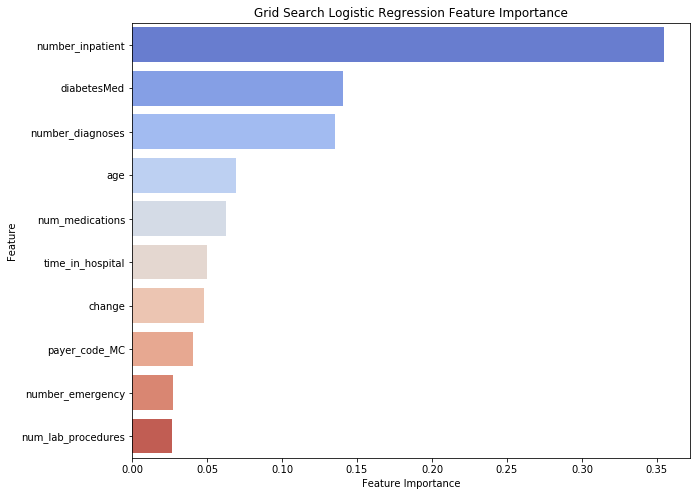

In [54]:
plot_feature_importance(lr_cv.best_estimator_.coef_.reshape(lr_cv.best_estimator_.coef_.shape[1],), X_train_res.columns, 'Grid Search Logistic Regression')

## Logistic Regression Bagging

In [55]:
lr_bagger = BaggingClassifier(lr_cv.best_estimator_, n_jobs=-1)
lr_bagger.fit(X_train_res, y_train_res)

BaggingClassifier(base_estimator=LogisticRegression(C=21.544346900318832,
                                                    class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='auto',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=None,
                                                    solver='lbfgs', tol=0.0001,
                                                    verbose=0,
                                                    warm_start=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=10,

<Figure size 720x576 with 0 Axes>

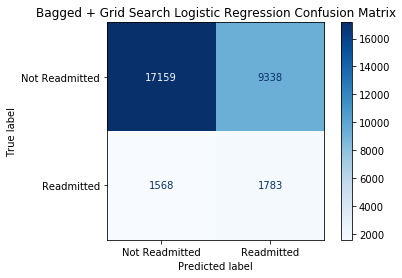

In [56]:
plot_cm(lr_bagger, "Bagged + Grid Search Logistic Regression")

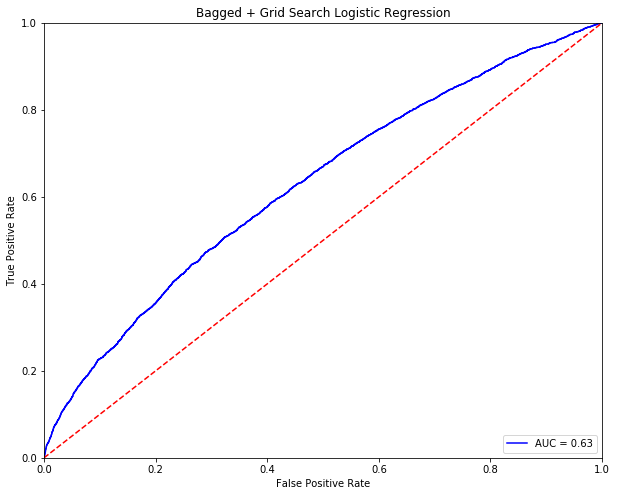

In [57]:
plot_roc_curve(lr_bagger, X_test, y_test, "Bagged + Grid Search Logistic Regression")

## Random Forest Classifier

- Hyperparamter Tuning

In [102]:
max_depth = list(range(10,50,10))
n_estimators = list(range(100,300,50))
max_features = [5,10,15,20]
bootstrap = ['True', 'False']


params_rf = {'max_depth':max_depth, 'n_estimators':n_estimators, 'max_features':max_features, 
             'bootstrap':bootstrap}

rf = RandomForestClassifier()

rf_grid = GridSearchCV(rf, param_grid=params_rf, scoring='roc_auc', n_jobs=-1, cv=5, verbose=1)

rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 44.3min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed: 108.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [103]:
rf_grid.best_estimator_

RandomForestClassifier(bootstrap='True', ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

<Figure size 720x576 with 0 Axes>

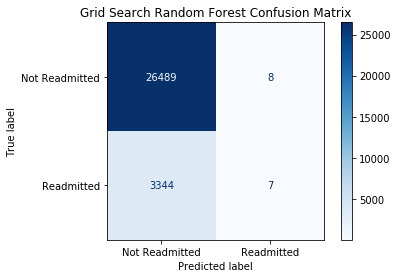

In [104]:
plot_cm(rf_grid.best_estimator_, "Grid Search Random Forest")

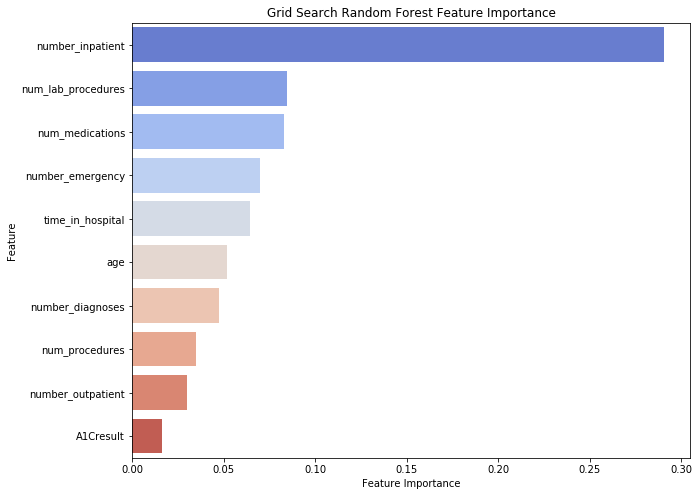

In [106]:
plot_feature_importance(rf_grid.best_estimator_.feature_importances_, X_train_res.columns, 'Grid Search Random Forest')

In [109]:
import pickle

filename = 'rfbestgrid.sav'

rf_best = rf_grid.best_estimator_

pickle.dump(rf_best, open(filename, 'wb'))

In [78]:
# load model 
import pickle

filename = 'rfbestgrid.sav'

rf_best = pickle.load(open(filename, 'rb'))

In [60]:
loaded_model

RandomForestClassifier(bootstrap='True', ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## XGBoost Classifier
- Hyperparamter Tuning

In [68]:
eta = np.arange(0.05,0.35,0.05)
max_depth = range(3,10,2)
min_child_weight = range(1,6,2)
gamma = [i/10 for i in range(0,5)]

params_xgb = {'eta':eta, 'max_depth':max_depth, 
              'min_child_weight':min_child_weight,
              'gamma':gamma}

xgb_grid = xgb.XGBClassifier()

xgb_clf = GridSearchCV(xgb_grid, param_grid=params_xgb, cv=5, n_jobs=-1, scoring='roc_auc', verbose=1)

xgb_clf.fit(X_train_res,y_train_res)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 66.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 209.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 302.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 418.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 565.9min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 571.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'eta': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ]),
                         'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'max_depth': ran

<Figure size 720x576 with 0 Axes>

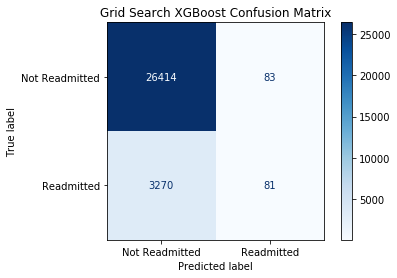

In [73]:
plot_cm(best_xgb, "Grid Search XGBoost")

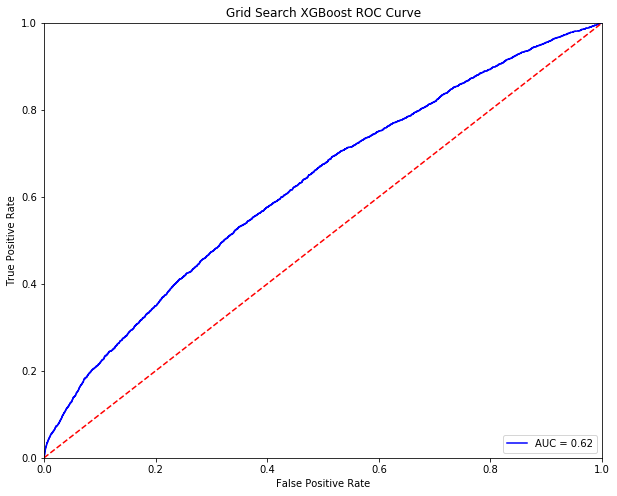

In [74]:
plot_roc_curve(best_xgb, X_test, y_test, "Grid Search XGBoost ROC Curve")

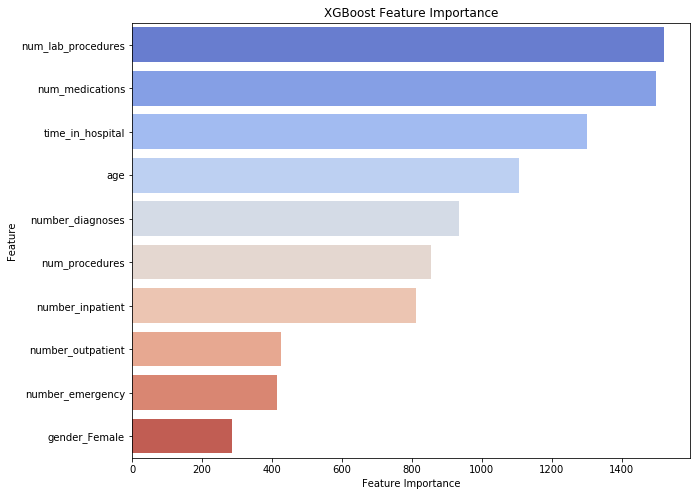

In [75]:
feature_important = best_xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

xgb_df = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

plot_feature_importance(xgb_df.score, xgb_df.index, "XGBoost")

In [71]:
import pickle

best_xgb = xgb_clf.best_estimator_

filename = 'xgb_tuned.sav'

xgb_pickle = best_xgb

pickle.dump(xgb_pickle, open(filename, 'wb'))

xgb_best = pickle.load(open(filename, 'rb'))

## Ensembling
- Ensemble all optimized estimators

In [79]:
voter = VotingClassifier(estimators = [('Grid Search Decision Trees',dt_cv),
                                       ('Grid Search Random Forest', rf_best),
                                       ('Grid Search Logistic Regression', lr_cv),
                                       ('Bagged Logistic Regresssion', lr_bagger),
                                       ('Grid Search XGBoost',best_xgb),], voting='soft')

voter.fit(X_train_res, y_train_res)


Fitting 5 folds for each of 448 candidates, totalling 2240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2240 out of 2240 | elapsed:  1.8min finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.7s finished


VotingClassifier(estimators=[('Grid Search Decision Trees',
                              GridSearchCV(cv=5, error_score=nan,
                                           estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                            class_weight=None,
                                                                            criterion='gini',
                                                                            max_depth=None,
                                                                            max_features=None,
                                                                            max_leaf_nodes=None,
                                                                            min_impurity_decrease=0.0,
                                                                            min_impurity_split=None,
                                                                            min_samples_leaf=1,
          

<Figure size 720x576 with 0 Axes>

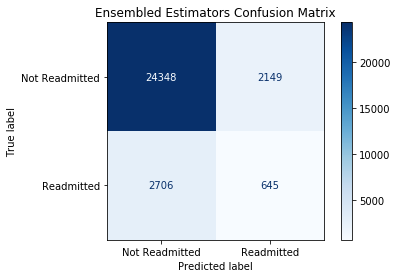

In [80]:
plot_cm(voter, 'Ensembled Estimators')

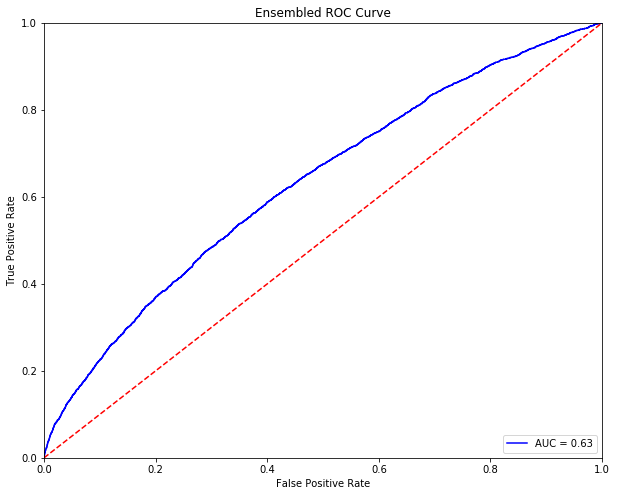

In [81]:
plot_roc_curve(voter, X_test, y_test, 'Ensembled ROC Curve')